In [2]:
import numpy as np
import pandas as pd

import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

raw_df = pd.read_csv(r'C:\Users\Admin\Desktop\E_commerce_proj\data\datainput\original_file.csv')

In [3]:
# số dòng và cột của dữ liệu
print("Số dòng và cột của dữ liệu: ",raw_df.shape)

Số dòng và cột của dữ liệu:  (15000, 43)


In [4]:
# kiểm tra xem dữ liệu có trùng lặp không
print("Số dòng trùng lặp: ",raw_df.duplicated().sum())

Số dòng trùng lặp:  0


In [5]:
# tên tất cả các cột của dữ liệu
print("Tên tất cả các cột của dữ liệu: ",raw_df.columns.tolist())

Tên tất cả các cột của dữ liệu:  ['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Customer ID', 'Payment Method', 'Return Status', 'Product Rating', 'Customer Segment', 'Platform', 'NumReturns', 'Customer_Score', 'Loyalty_Points', 'Discount_Usage', 'Referral_Count', 'MntAccessories', 'MntElectronics', 'MntClothing', 'MntHomeDecor', 'NumGiftPurchases', 'NumHolidayPurchases', 'NumSpecialOffers', 'NumSocialMediaShares', 'NumLoyaltyVisits']


Ý nghĩa của từng column


index – Chỉ số dòng (có thể được tạo tự động).

Order ID – Mã đơn hàng.

Date – Ngày đặt hàng.

Status – Trạng thái đơn hàng (VD: Shipped, Cancelled).

Fulfilment – Phương thức thực hiện đơn hàng (Amazon hoặc người bán).

Sales Channel – Kênh bán hàng (VD: Amazon, Amazon.in).

ship-service-level – Mức độ dịch vụ vận chuyển (VD: Standard, Expedited).

Style – Tên hoặc mã kiểu sản phẩm.

SKU – Mã hàng trong kho (Stock Keeping Unit).

Category – Danh mục sản phẩm (VD: kurta, set).

Size – Kích cỡ sản phẩm.

ASIN – Mã định danh sản phẩm của Amazon (Amazon Standard Identification Number).

Courier Status – Trạng thái giao hàng bởi đơn vị vận chuyển.

Qty – Số lượng sản phẩm đã đặt.

currency – Loại tiền tệ sử dụng (VD: INR).

Amount – Tổng số tiền thanh toán cho đơn hàng.

ship-city – Thành phố giao hàng.

ship-state – Bang/tỉnh giao hàng.

ship-postal-code – Mã bưu điện của địa chỉ giao hàng.

ship-country – Quốc gia giao hàng.

promotion-ids – Mã khuyến mãi (nếu có).

B2B – Đơn hàng thuộc loại doanh nghiệp đến doanh nghiệp (B2B) hay không.

fulfilled-by – Bên chịu trách nhiệm hoàn tất đơn hàng (VD: Amazon hoặc người bán).

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 15000 non-null  int64  
 1   Order ID              15000 non-null  object 
 2   Date                  15000 non-null  object 
 3   Status                15000 non-null  object 
 4   Fulfilment            15000 non-null  object 
 5   Sales Channel         15000 non-null  object 
 6   ship-service-level    15000 non-null  object 
 7   Style                 15000 non-null  object 
 8   SKU                   6120 non-null   object 
 9   Category              6030 non-null   object 
 10  Size                  15000 non-null  object 
 11  ASIN                  15000 non-null  object 
 12  Courier Status        5694 non-null   object 
 13  Qty                   15000 non-null  int64  
 14  currency              5672 non-null   object 
 15  Amount             

`Nhận xét 1:`
- Trường Currency, Amount,... có nulls rất lớn
- Trường Date chứa dữ liệu về ngày (date) mà khách hàng được thêm vào CSDL của công ty có kiểu dữ liệu là dtype=**object**
- Hầu hết là dữ liệu dttype = object
- Cần chuyển về dạng type = date
-Qty, Amount cần chuyển về type = int, float..

In [7]:
import pandas as pd


missing_values = raw_df.isnull().sum()                  # Đếm số lượng NaN
missing_values = missing_values[missing_values > 0] # Chỉ lấy cột có giá trị thiếu
missing_df = missing_values.reset_index()           # Chuyển thành DataFrame
missing_df.columns = ['Cột', 'Số lượng thiếu']      # Đặt tên cột
print("Các cột bị thiếu dữ liệu")
print(missing_df)


Các cột bị thiếu dữ liệu
                 Cột  Số lượng thiếu
0                SKU            8880
1           Category            8970
2     Courier Status            9306
3           currency            9328
4             Amount            9315
5          ship-city            8945
6         ship-state            9090
7   ship-postal-code               5
8       ship-country            9005
9      promotion-ids           11125
10      fulfilled-by           12772


In [8]:
import pandas as pd




# Danh sách các giá trị lỗi đặc biệt cần kiểm tra
weird_values = ['####', '###', '##', '#', '###@', 'NaN', 'NULL', '', '##9&', '#8#$', '#2##']

# Hàm đếm giá trị lỗi đặc biệt trong từng cột
def count_weird_values(df, weird_list):
    weird_counts = {}
    for col in df.columns:
        count = df[col].astype(str).apply(lambda x: x.strip() in weird_list).sum()
        if count > 0:
            weird_counts[col] = count
    return pd.DataFrame(list(weird_counts.items()), columns=["Cột", "Số lượng giá trị lỗi"])

# Gọi hàm để kiểm tra trên DataFrame
weird_value_counts = count_weird_values(raw_df, weird_values)

# Hiển thị kết quả
print(weird_value_counts)


Empty DataFrame
Columns: [Cột, Số lượng giá trị lỗi]
Index: []


- Vậy là không có cột nào có giá trị lỗi như ## #$..
- Theo trực quan ta thấy đa số chỉ là lỗi để trống data --> ta có thể sửa nó về nan
- Vẽ các biểu đồ thể hiện dữ liệu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 15000 non-null  int64  
 1   Order ID              15000 non-null  object 
 2   Date                  15000 non-null  object 
 3   Status                15000 non-null  object 
 4   Fulfilment            15000 non-null  object 
 5   Sales Channel         15000 non-null  object 
 6   ship-service-level    15000 non-null  object 
 7   Style                 15000 non-null  object 
 8   SKU                   6120 non-null   object 
 9   Category              6030 non-null   object 
 10  Size                  15000 non-null  object 
 11  ASIN                  15000 non-null  object 
 12  Courier Status        5694 non-null   object 
 13  Qty                   15000 non-null  int64  
 14  currency              5672 non-null   object 
 15  Amount             

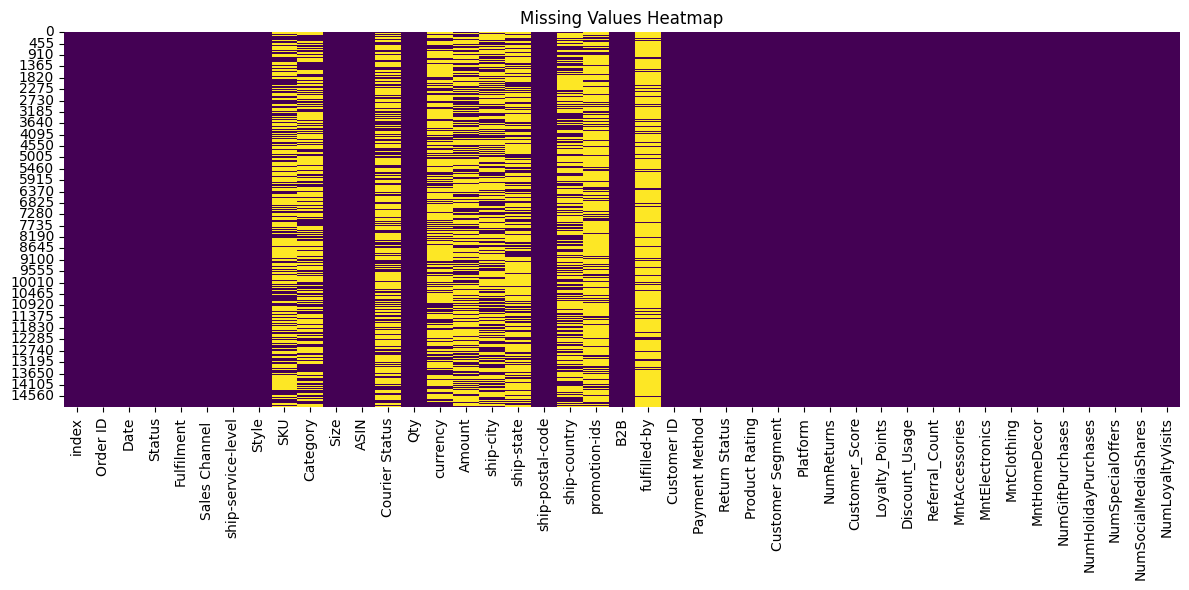

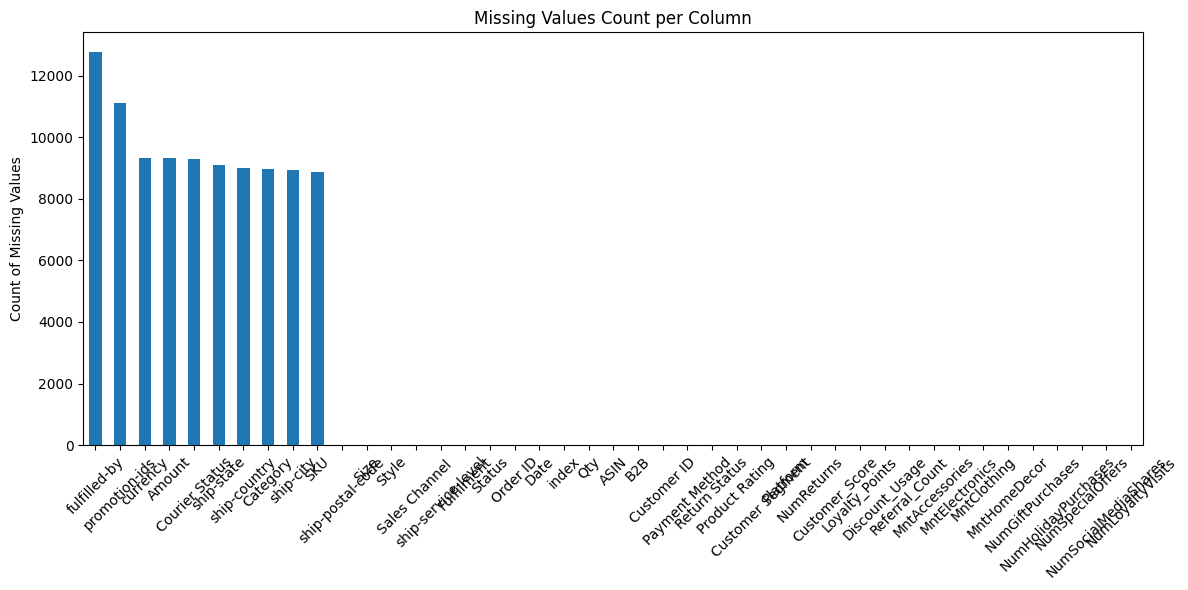

In [9]:
# show dataframe


# Display basic info
basic_info = raw_df.info()

# Visualize missing values heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(raw_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

# Visualize number of missing values per column
missing_counts = raw_df.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
missing_counts.plot(kind='bar')
plt.title('Missing Values Count per Column')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




1. Biểu đồ heatmap các ô trống (missing values)
Màu vàng là ô bị thiếu.

Có khá nhiều các dữ liệu bị thiếu

 2. Biểu đồ cột – Số lượng ô trống trên mỗi cột
Thể hiện rõ cột nào có nhiều dữ liệu bị thiếu nhất (ví dụ: fulfilled-by, promotion-ids, currency,...).


